In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, roc_curve, f1_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import defaultdict
import collections

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import re
import warnings
import scikitplot as skplt
warnings.filterwarnings("ignore")

In [2]:
#1.PPI database
PPP_data = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\PPP_Projects_Total.csv")
#add experience
country_experience = PPP_data.groupby(['countrycode', 'IY']).size().reset_index().sort_values(['countrycode', 'IY'])
country_experience.columns = ['countrycode', 'IY', 'experience']
unique_country = country_experience.countrycode.unique()
years = np.arange(1990, 2020)

for country in unique_country:
    for year in years:
        if year not in country_experience.loc[country_experience.countrycode==country, 'IY'].values:
            country_experience = country_experience.append({'countrycode': country, 'IY': year, 'experience': 0}, ignore_index=True)

country_experience = country_experience.sort_values(by=['countrycode', 'IY']).set_index(np.arange(country_experience.shape[0]))
country_experience['cum_experience'] = country_experience.groupby('countrycode')['experience'].cumsum()
country_experience.drop(columns=['experience'], inplace=True)

country_experience['shifted_country_experience_1'] = country_experience.groupby('countrycode')['cum_experience'].shift(1).fillna(method='bfill')
country_experience.drop(columns=['cum_experience'], inplace=True)

In [3]:
country_sector_experience = PPP_data.groupby(['countrycode', 'IY', 'sector']).size().reset_index().sort_values(['countrycode', 'IY'])
country_sector_experience.columns = ['countrycode', 'IY', 'sector', 'sector_experience']
unique_sector_country = country_sector_experience.countrycode.unique()
unique_sector = country_sector_experience.sector.unique()
years = np.arange(1990, 2020)

for country in unique_sector_country:
    for year in years:
        if year not in country_sector_experience.loc[country_sector_experience.countrycode==country, 'IY'].values:
            for sectors in unique_sector:
                country_sector_experience = country_sector_experience.append({'countrycode': country, 
                                                                              'IY': year, 
                                                                              'sector': sectors, 
                                                                              'sector_experience': 0}, ignore_index=True)
        else:
            for sectors in unique_sector:
                if sectors not in country_sector_experience.loc[(country_sector_experience.countrycode==country) & (country_sector_experience.IY==year),
                                                                'sector'].values:
                    country_sector_experience = country_sector_experience.append({'countrycode': country, 
                                                                                  'IY': year, 
                                                                                  'sector': sectors, 
                                                                                  'sector_experience': 0}, ignore_index=True)

country_sector_experience = country_sector_experience.sort_values(by=['countrycode', 'IY']).set_index(np.arange(country_sector_experience.shape[0]))
country_sector_experience['cum_sector_experience'] = country_sector_experience.groupby(['countrycode', 'sector'])['sector_experience'].cumsum()
country_sector_experience.drop(columns=['sector_experience'], inplace=True)

country_sector_experience['shifted_sector_experience_1'] = country_sector_experience.groupby(['countrycode', 'sector'])['cum_sector_experience'].shift(1).fillna(method='bfill')
country_sector_experience.drop(columns=['cum_sector_experience'], inplace=True)

In [4]:
PPP_data = PPP_data.merge(country_experience,
                          left_on=['countrycode', 'IY'],
                          right_on=['countrycode', 'IY'],
                          how='left')

In [5]:
PPP_data = PPP_data.merge(country_sector_experience,
                          left_on=['countrycode', 'IY', 'sector'],
                          right_on=['countrycode', 'IY', 'sector'],
                          how='left')

In [6]:
PPP_data.loc[:, 'PCO'] = PPP_data['PCO'].str.replace('\n', '') 
PPP_data.loc[~PPP_data.PCO.isnull() & (PPP_data.PCO != ''), 
             'sponsor_number'] = PPP_data[~PPP_data.PCO.isnull() & (PPP_data.PCO != '')].PCO.str.split('/').map(lambda x: x[2])
PPP_data.sponsor_number = PPP_data.sponsor_number.replace('', np.nan)

PPP_data.loc[~PPP_data.PCO.isnull() & (PPP_data.PCO != ''), 
             'foreign_country'] = PPP_data[~PPP_data.PCO.isnull() & (PPP_data.PCO != '')].PCO.str.split('/').map(lambda x: x[1])

PPP_data.foreign_country = PPP_data.foreign_country.replace('N', 'No')
PPP_data.loc[(PPP_data.foreign_country!='No') & (~PPP_data.foreign_country.isnull()), 'foreign_country'] = 'Yes'

PPP_data = PPP_data.merge(country_sector_experience,
                          left_on=['countrycode', 'IY', 'sector'],
                          right_on=['countrycode', 'IY', 'sector'],
                          how='left')

In [7]:
#2.GDP per capita
GDP_per_capita = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\GDP per Capita.csv")
#3.Tax as GDP
tax_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Tax as GDP.csv")
#4.GDP deflator(inflation rate)
GDP_deflator = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\GDP deflator.csv")
#5.life expectnacy
life_expectnacy = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Life expectnacy.csv")
#6.real effective change
real_effective_change = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Real effect change.csv")
#7.electric consumption
electric_consumption = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Electric consumption.csv")
#8.domestic credit to private
domestic_credit_to_private = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Domestic credit to private.csv")
#9.Import as GDP
imports_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Imports as GDP.csv")
#10.Export as GDP
exports_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Exports as GDP.csv")
#11.Control of corruption
control_of_corruption = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Control of corruption.csv", encoding='cp1252')
#12.Government of effectiveness
government_effectiveness = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Government effectiveness.csv", encoding='cp1252')
#13.Political stability
political_stability = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Political Stability and Absence of Violence.csv", encoding='cp1252')
#14.regulatory quality
regulatory_quality = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Regulatory quality.csv", encoding='cp1252')
#15.Rule of law
rule_of_law = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Rule of law.csv", encoding='cp1252')
#16.voice and accountability
voice_and_accountability = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Voice and accountability.csv", encoding='cp1252')

dataset = [GDP_per_capita, 
           tax_as_GDP, 
           GDP_deflator, 
           life_expectnacy, 
           real_effective_change,
           electric_consumption,
           domestic_credit_to_private, 
           imports_as_GDP, 
           exports_as_GDP, 
           control_of_corruption,
           government_effectiveness, 
           political_stability, 
           regulatory_quality, 
           rule_of_law, 
           voice_and_accountability]

dataset_name = ['GDP_per_capita', 
                'tax_as_GDP', 
                'GDP_deflator', 
                'life_expectnacy', 
                'real_effective_change',
                'electric_consumption', 
                'domestic_credit_to_private', 
                'imports_as_GDP', 
                'exports_as_GDP', 
                'control_of_corruption',
                'government_effectiveness',
                'political_stability', 
                'regulatory_quality', 
                'rule_of_law', 
                'voice_and_accountability']

def process_data(original_data):
    new_data = original_data.copy()
    new_data.replace('..', np.nan, inplace=True)
    new_data.drop(columns=['Series Name', 'Series Code', 'Country Name'], inplace=True)
    new_data.set_index('Country Code', inplace=True)
    new_data.dropna(how='all', inplace=True)
    new_data.columns = [name.split(' ')[0] for name in list(new_data.columns)]
    new_data = new_data.fillna(axis=1, method='bfill')
    new_data = new_data.fillna(axis=1, method='ffill')
    return new_data

for i in np.arange(len(dataset)):
    dataset[i] = process_data(dataset[i])

def meltdata(raw_data, column_name):
    new_data = pd.melt(raw_data.reset_index(), 
                       id_vars=['Country Code'], 
                       var_name=['Year'],
                       value_vars=raw_data.columns,
                       value_name=column_name)   
    new_data.Year = new_data.Year.astype('int64', copy=False)
    return new_data

for i,name in zip(np.arange(len(dataset)), dataset_name):
    dataset[i] = meltdata(dataset[i], name).copy()
    dataset[i].rename(columns={'Country Code': 'countrycode', 
                               'Year': 'IY'}, 
                      inplace=True)
    dataset[i][name] = dataset[i].groupby('countrycode')[name].shift(1).fillna(method='bfill')

for data in dataset:
    PPP_data= PPP_data.merge(data, 
                             left_on=['countrycode', 'IY'], 
                             right_on=['countrycode', 'IY'], 
                             how='left')

In [8]:
#copy data out.
data = PPP_data.copy()

In [9]:
data.shape

(7096, 63)

In [12]:
data.drop(columns=['country',
                   'regionname',                   
                   'region',
                   'adminregionname',
                   'Description',
                   'FCY',
                   'bid_crit',
                   'incomelevelname',
                   'lendingtypename',
                   'TIGS',
                   'PCO',
                   'shareborder',
                   'GDP',
                   'population',
                   'investment_real',
                   'realphysicalassets',
                   'income'], inplace=True)

data.replace('..', np.nan, inplace=True)

data.replace({'status_n': {'Cancelled': 'fail', 
                           'Distressed': 'fail', 
                           'Active': 'success',
                           'Concluded': 'success'}}, inplace=True)

float_value = ['GDP_per_capita', 
               'tax_as_GDP', 
               'GDP_deflator', 
               'life_expectnacy', 
               'real_effective_change',
               'electric_consumption', 
               'domestic_credit_to_private', 
               'imports_as_GDP', 
               'exports_as_GDP', 
               'control_of_corruption',
               'government_effectiveness', 
               'political_stability', 
               'regulatory_quality', 
               'rule_of_law', 
               'voice_and_accountability',
               'shifted_country_experience_1',
               'shifted_sector_experience_1',
               'period',
               'CPI2019',
               'bordercountries', 
               'private', 
               'physical', 
               'period',
               'investment', 
               'pcapacity',
               'sponsor_number',
               'IY']
nominal_value = ['IDA', 
                 'Region',
                 'type', 
                 'stype', 
                 'sector'
                 'ssector',
                 'Segment', 
                 'UP', 
                 'PublicDisclosure', 
                 'PRS', 
                 'Renewables', 
                 'MLS', 
                 'GGC',
                 'BS',
                 'lendingtype'
                 'adminregion',
                 'foreign_country']
ordinal_value = ['incomelevel']

for float_column in float_value:
    data[float_column] = data[float_column].astype(float)

# BS (Bilateral Support) replace with NO and Yes, 
data.loc[(data.BS!='No') & (~data.BS.isnull()), 'BS'] = 'Yes'
#private convert to categorical data.
#physical, investment, pcapacity will be converted to np.log
to_log = ['physical', 'investment', 'pcapacity']
for column in to_log:
    data[column] = np.log(data[column] + 0.01)

#split the data
X = data[data.columns[data.columns!='status_n']]
y = data['status_n']
#income value is ordinal value
mapper = {'LIC': 1, 
          'HIC': 4, 
          'LMC': 2, 
          'UMC': 3}
X.loc[:, 'incomelevel'] = X.incomelevel.map(mapper)

predicted_status = {'success': 0, 
                    'fail': 1}
y = y.map(predicted_status)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y, shuffle=True)

In [19]:
def fillna_nominal(train_dataset, test_dataset, group_list, column):
    train = train_dataset.copy()
    test = test_dataset.copy()
    mode_in_train = train.groupby(group_list)[column].agg(pd.Series.mode).to_frame().reset_index()
    # if no mode for current group, then fill with the mode in current column.
    for index, row in mode_in_train.iterrows():
        if type(row[column]) == np.ndarray:
            mode_in_train.loc[index, column] = train[column].mode()[0]
    for i, rows in mode_in_train.iterrows():
        train_index = (train[group_list[0]] == rows[group_list[0]])
        test_index = (test[group_list[0]] == rows[group_list[0]])
        for t in np.arange(len(group_list)):
            train_index = train_index & (train[group_list[t]] == rows[group_list[t]])
            test_index = test_index & (test[group_list[t]] == rows[group_list[t]])
        train.loc[train_index, column] = train.loc[train_index, column].fillna(rows[column])
        test.loc[test_index, column] = test.loc[test_index, column].fillna(rows[column])
        
    train.loc[:, column] = train[column].fillna(train[column].mode()[0])
    test.loc[:, column] = test[column].fillna(train[column].mode()[0])       
    return train, test
def fillna_numerical(train_dataset, test_dataset, group_list, column):
    train = train_dataset.copy()
    test = test_dataset.copy()
    mean_in_train = train.groupby(group_list)[column].mean().to_frame().reset_index()
    for i, rows in mean_in_train.iterrows():
        train_index = (train[group_list[0]] == rows[group_list[0]])
        test_index = (test[group_list[0]] == rows[group_list[0]])
        for t in np.arange(len(group_list)):
            train_index = train_index & (train[group_list[t]] == rows[group_list[t]])
            test_index = test_index & (test[group_list[t]] == rows[group_list[t]])
        train.loc[train_index, column] = train.loc[train_index, column].fillna(rows[column])
        test.loc[test_index, column] = test.loc[test_index, column].fillna(rows[column])
        
    train.loc[:, column] = train[column].fillna(train[column].mean())
    test.loc[:, column] = test[column].fillna(train[column].mean())
    return train, test   

In [20]:
missing_categorical = {'lendingtype': ['countrycode', 'ssector'],
                       'GGC': ['countrycode', 'ssector'],
                       'PRS': ['countrycode', 'ssector'],
                       'BS': ['countrycode', 'ssector'],
                       'adminregion': ['Region'],
                       'incomelevel': ['Region'],
                       'foreign_country': ['countrycode', 'ssector']}

for column, group_list in missing_categorical.items():
    if (X_train[column].isnull().sum() != 0) | (X_test[column].isnull().sum() != 0):
        X_train, X_test = fillna_nominal(X_train, X_test, group_list, column)

missing_numerical = {'period': ['stype', 'sector', 'Region', 'countrycode'],
                     'pcapacity': ['stype', 'sector', 'Region', 'countrycode'],
                     'private': ['stype', 'ssector', 'countrycode'],
                     'physical': ['stype', 'ssector', 'countrycode'],
                     'investment': ['stype', 'ssector', 'countrycode'],
                     'tax_as_GDP': ['Region'],
                     'real_effective_change': ['Region'],
                     'domestic_credit_to_private': ['Region'],
                     'rule_of_law': ['Region'],
                     'imports_as_GDP': ['Region'],
                     'exports_as_GDP': ['Region'],
                     'electric_consumption': ['Region'],
                     'sponsor_number': ['countrycode', 'ssector']}

for column, group_list in missing_numerical.items():
    if (X_train[column].isnull().sum() != 0) | (X_test[column].isnull().sum() != 0):
        X_train, X_test = fillna_numerical(X_train, X_test, group_list, column)

In [21]:
X_train.drop(columns=['countrycode'], inplace=True)
X_test.drop(columns=['countrycode'], inplace=True)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [22]:
X_train.shape

(5322, 44)

In [23]:
y_train.shape

(5322,)

In [23]:
X_test.shape

(1774, 44)

In [26]:
y_test.shape

(1774,)

In [163]:
X_train.shape

(5322, 111)

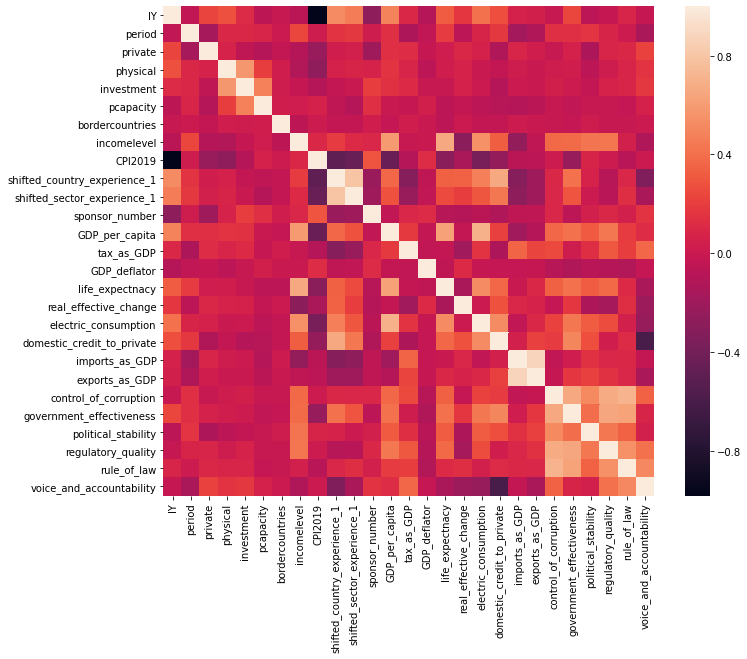

In [35]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(X_train.corr())

In [37]:
X_train.corr()[X_train.corr() > 0.5]

,IY,period,private,physical,investment,pcapacity,bordercountries,incomelevel,CPI2019,shifted_country_experience_1,...,electric_consumption,domestic_credit_to_private,imports_as_GDP,exports_as_GDP,control_of_corruption,government_effectiveness,political_stability,regulatory_quality,rule_of_law,voice_and_accountability
IY,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.522574,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
period,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
private,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
physical,NaN,NaN,NaN,1.000000,0.581035,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
investment,NaN,NaN,NaN,0.581035,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pcapacity,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bordercountries,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
incomelevel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,...,0.548010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CPI2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shifted_country_experience_1,0.522574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,NaN,0.654256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
#to make sure the train and test dataset have the same shape
train_objs_num = len(X_train)
combine_dataset = pd.concat(objs=[X_train, X_test], axis=0)
dataset_preprocessed = pd.get_dummies(combine_dataset, columns=X_train.columns[X_train.dtypes == object], drop_first=True)
X_train = dataset_preprocessed[:train_objs_num]
X_test = dataset_preprocessed[train_objs_num:]
#scaling data
scaler = RobustScaler()
numeric_column = X_train.columns[X_train.dtypes == 'float64']
X_train[numeric_column] = scaler.fit_transform(X_train[numeric_column])
X_test[numeric_column] = scaler.transform(X_test[numeric_column])

In [25]:
X_train.drop(columns=['sector_ICT'], inplace=True)
X_test.drop(columns=['sector_ICT'], inplace=True)

In [26]:
X_train.drop(columns=['IY'], inplace=True)
X_test.drop(columns=['IY'], inplace=True)

In [31]:
X_bal, y_bal = SMOTE(sampling_strategy='minority',random_state=0).fit_resample(
    X_train,
    y_train)

X_bal = pd.DataFrame(X_bal, columns=X_train.columns)
y_bal = pd.DataFrame(y_bal, columns=['status_n'])
# ###########
balanced = X_bal.join(y_bal)
bal_corr = balanced.corr()

In [123]:
no_outliers = pd.DataFrame(balanced.copy())
cols = bal_corr.status_n.index[:-1]
for col in cols:
    correlation = bal_corr.loc['status_n', col]
    if np.abs(correlation) > 0.05:##threshold
        nonfrauds = no_outliers.loc[no_outliers.status_n==0, col]
        frauds = no_outliers.loc[no_outliers.status_n==1, col]
        
        all_values = no_outliers.loc[:,col]
        q25, q75 = np.percentile(all_values, 25), np.percentile(all_values, 75)
        iqr = q75 - q25
        cutoff = iqr * 8 ##out
        lower, upper = q25 - cutoff, q75 + cutoff
        if correlation > 0: 
            no_outliers.drop(index=nonfrauds[nonfrauds>upper].index,inplace=True)
            no_outliers.drop(index=frauds[frauds<lower].index,inplace=True)
        elif correlation < 0: 
            no_outliers.drop(index=nonfrauds[nonfrauds<lower].index,inplace=True)
            no_outliers.drop(index=frauds[frauds>upper].index,inplace=True)        

feat_sel =pd.DataFrame(no_outliers.copy())
new_corr = feat_sel.corr()
for col in new_corr.status_n.index[:-1]:
    if np.abs(new_corr.loc['status_n', col]) < 0.04:## i
        feat_sel.drop(columns=col, inplace=True)

X_final_train = feat_sel.drop('status_n', 1)
y_final_train = feat_sel.status_n
X_final_train, y_final_train = SMOTE(sampling_strategy='minority',random_state=0).fit_resample(
                               X_final_train,
                               y_final_train)

X_final_test = X_test[X_final_train.columns]
y_final_test = y_test

In [105]:
! pip install -q scikit-plot

In [91]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score

In [95]:
def auc_score(model):
    model.fit(X_final_train, y_final_train)
    y_predict = model.predict_proba(X_final_test)
    y_failed = y_predict[:, 1]
    roc_auc = roc_auc_score(y_final_test, y_failed)
    precision, recall, _ = precision_recall_curve(y_final_test, y_failed)
    recall_auc = auc(recall, precision)
    return roc_auc, recall_auc    

In [92]:
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

In [82]:
dummy_model = DummyClassifier(strategy='stratified', random_state=2)
print("Dummy model:", auc_score(dummy_model))
logistic_model = LogisticRegression(solver='lbfgs')
print("Logistic model:", auc_score(logistic_model))

Dummy model: (0.4703004802584045, 0.25962848565907237)
Logistic model: (0.7697224701432275, 0.09683094972827984)


In [116]:
#clf and upsample
clf = RandomForestClassifier(class_weight='balanced', random_state=1)
param_grid = {'n_estimators': [int(x) for x in np.linspace(700, 2000, 25)],
              'max_features': ['auto', 'sqrt'], 
              'max_depth': [int(x) for x in np.linspace(10, 80, 30)],
              'min_samples_split': [int(x) for x in np.linspace(2, 30, 20)],
              'min_samples_leaf': [int(x) for x in np.linspace(2, 10, 5)],
              'bootstrap': [True, False]}

cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=2, random_state=1)
clf_random_grid = RandomizedSearchCV(clf,
                                     param_grid, 
                                     refit=True, 
                                     verbose=-1, 
                                     cv=cv,
                                     n_jobs=-1,
                                     random_state=123,
                                     scoring=make_scorer(f2_measure))

clf_random_grid.fit(X_final_train, y_final_train)

best_model = clf_random_grid.best_estimator_                                    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 11.3min finished


In [124]:
#clf and upsample
clf = RandomForestClassifier(random_state=1)
param_grid = {'n_estimators': [int(x) for x in np.linspace(700, 2000, 25)],
              'max_features': ['auto', 'sqrt'], 
              'max_depth': [int(x) for x in np.linspace(10, 80, 30)],
              'min_samples_split': [int(x) for x in np.linspace(2, 30, 20)],
              'min_samples_leaf': [int(x) for x in np.linspace(2, 30, 20)],
              'bootstrap': [True, False]}
clf_random_grid = RandomizedSearchCV(clf,
                                     param_grid, 
                                     refit=True, 
                                     verbose=-1, 
                                     cv=2,
                                     n_jobs=-1,
                                     random_state=123)
random_forest_result = []
clf_random_grid.fit(X_final_train, y_final_train)
pred_clf_upsample = cross_val_predict(clf_random_grid.best_estimator_,
                                          X_final_test,
                                          y_final_test,                                      
                                          method='predict_proba',
                                          cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   22.9s finished


In [125]:
clf_random_grid.best_params_

{'n_estimators': 862,
 'min_samples_split': 19,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': 55,
 'bootstrap': False}

In [117]:
print('Best: %f using %s' % (clf_random_grid.best_score_, clf_random_grid.best_params_))

Best: 0.992672 using {'n_estimators': 1729, 'min_samples_split': 22, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}


In [118]:
pred_clf_upsample = best_model.predict_proba(X_final_test)

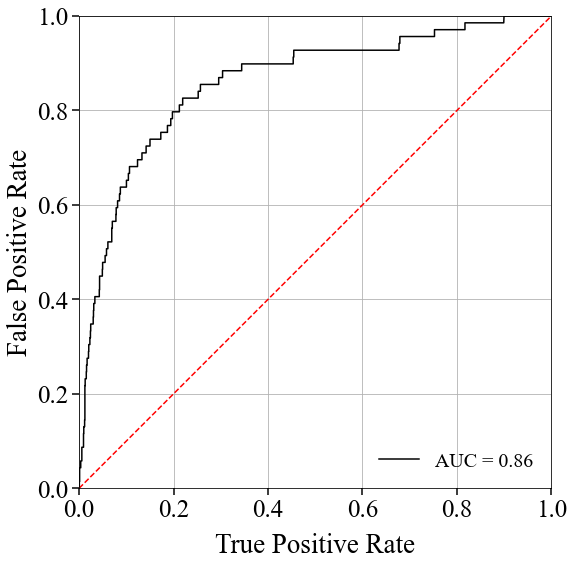

In [126]:
plot_roc(y_final_test, pred_clf_upsample[:,1])

No handles with labels found to put in legend.


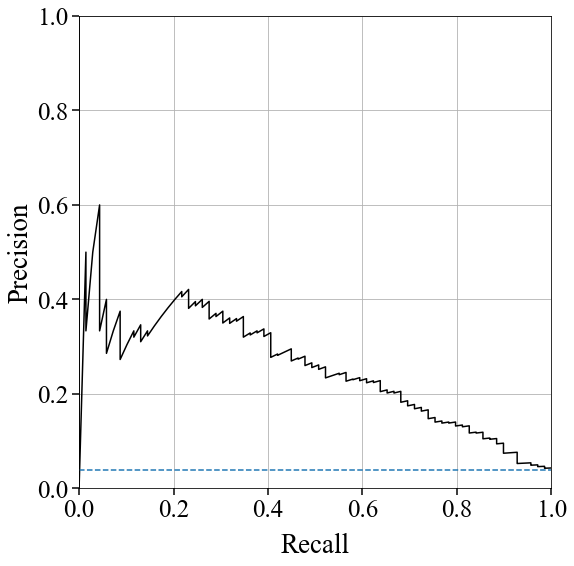

In [127]:
plot_recall_precision(y_test, pred_clf_upsample[:,1])

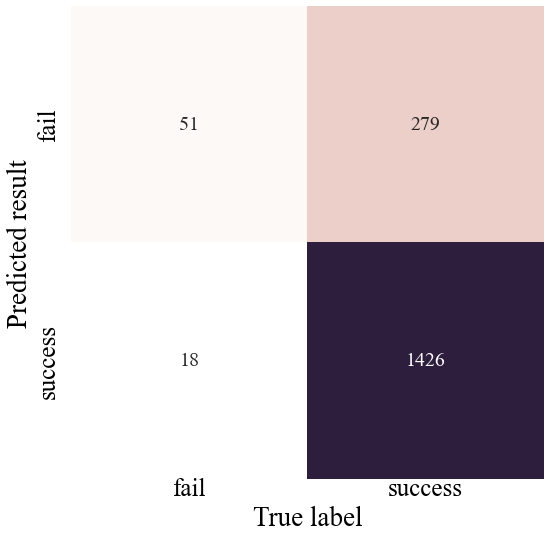

In [133]:
plot_cm(y_test, pred_clf_upsample[:, 1], 0.06)#0.1268

In [303]:
xgb_model = xgb.XGBClassifier(random_state=1)

param_grid = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.03, 0.05, 0.1], #so called `eta` value
              'max_depth': [4, 6, 8, 10],
              'min_child_weight': [int(x) for x in np.linspace(2, 30, 20)],
              'silent': [1],
              'subsample': [0.7, 0.8, 0.9],
              'colsample_bytree': [0.7],
              'n_estimators': [int(x) for x in np.linspace(700, 2000, 25)], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}

clf = RandomizedSearchCV(xgb_model, param_grid, n_jobs=5, 
                         cv=StratifiedKFold(n_splits=5, shuffle=True), 
                         scoring='roc_auc',
                         verbose=2, refit=True)

xgb_result = []

for k,v in data_dict.items():
    clf.fit(v[0][0], v[0][1])
    best_model = clf_random_grid.best_estimator_
    pred_clf_upsample = best_model.predict_proba(v[0][2])  
    xgb_result.append(pred_clf_upsample)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  4.6min finished


[16:06:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [276]:
clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=6, missing=-999, monotone_constraints='()',
              n_estimators=1187, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=1337, silent=1, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

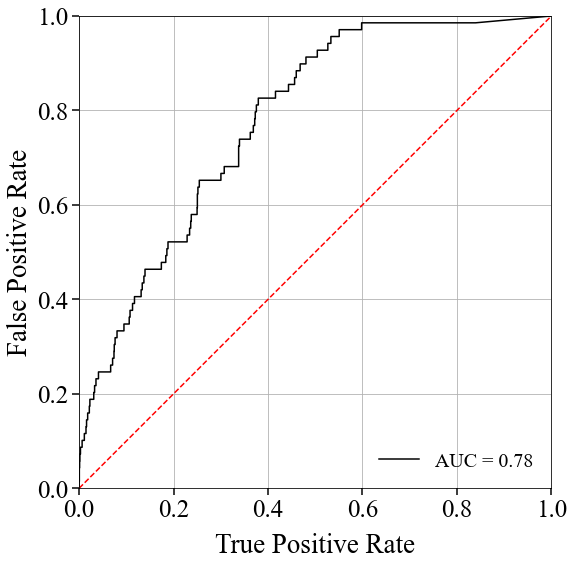

In [304]:
plot_roc(y_test, xgb_result[0][:,1])

No handles with labels found to put in legend.


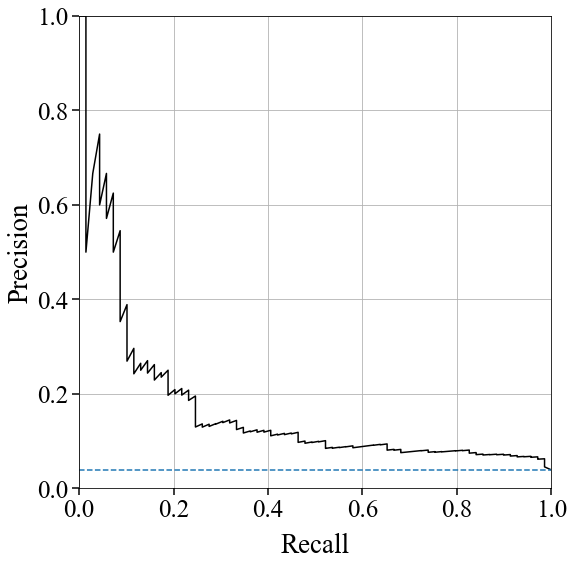

In [305]:
for i in xgb_result:
    plot_recall_precision(y_test, i[:,1])

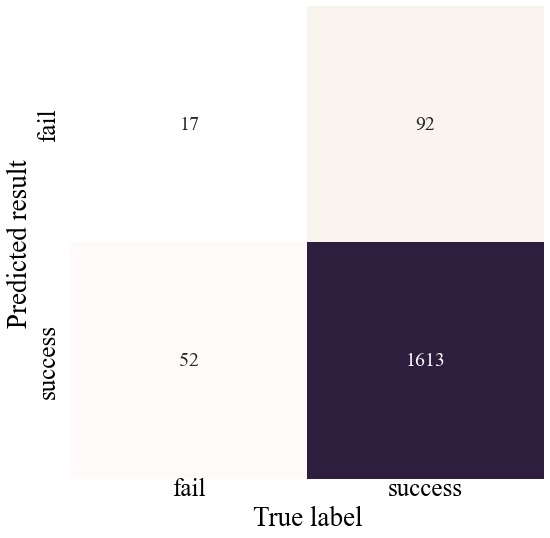

In [306]:
plot_cm(y_test, xgb_result[0][:, 1], 0.3)#0.1268

In [267]:
xgb_result[0][:, 1]

array([0.39186606, 0.3974766 , 0.39186606, ..., 0.41774422, 0.3972671 ,
       0.3908563 ], dtype=float32)

In [33]:
def plot_roc(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)   
    ax.plot(fpr, tpr, 'k', label = 'AUC = %0.2f' % roc_auc)
    ax.set_xlabel("True Positive Rate", fontsize=27, fontname='times new roman', labelpad=10)
    ax.set_ylabel("False Positive Rate", fontsize=27, fontname='times new roman', labelpad=4)
    ax.legend(loc='lower right', frameon=False, prop={'family':'Times new roman', 'size':20})
    ax.plot([0, 1], [0, 1],'r--')
    ax.tick_params(axis='both', length=7, labelsize=25, width=1.5, color='black')
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    plt.axis('square')
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)
    plt.savefig(r"C:\PPP\Thesis\Paper3\ROC.png", dpi=1000)

def plot_recall_precision(y_true, y_pred):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)   
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    ax.plot(recall, precision, 'k')
    no_skill = y_true.sum()/len(y_true)
    ax.plot([0, 1], [no_skill, no_skill], linestyle='--')
    ax.set_xlabel("Recall", fontsize=27, fontname='times new roman', labelpad=10)
    ax.set_ylabel("Precision", fontsize=27, fontname='times new roman', labelpad=4)
    ax.legend(frameon=False, prop={'family':'Times new roman', 'size':20})
    ax.tick_params(axis='both', length=7, labelsize=25, width=1.5, color='black')
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    plt.axis('square')
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)
    plt.savefig(r"C:\PPP\Thesis\Paper3\precision-recall.png", dpi=1000)


def plot_cm(labels, predictions, p):
    cm = confusion_matrix(labels, predictions > p)
    new_cm = np.array([[0, 0], [0, 0]])
    new_cm[0, 0] = cm[1, 1]
    new_cm[0, 1] = cm[0, 1]
    new_cm[1, 0] = cm[1, 0]
    new_cm[1, 1] = cm[0, 0]
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)  

    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    sns.heatmap(new_cm, annot=True, fmt='.0f', cmap=cmap, annot_kws={"size":20, 'fontname': 'times new roman'}, cbar=False)

    
    plt.yticks([0.5,1.5], [ 'fail', 'success'],va='center')
    plt.xticks([0.5,1.5], [ 'fail', 'success'],va='center')
    
    ax.set_xlabel("True label", fontsize=27, fontname='times new roman')
    ax.set_ylabel("Predicted result", fontsize=27, fontname='times new roman')
    
    ax.tick_params(axis='x', pad=10)
    ax.tick_params(axis='y', pad=10)
    ax.tick_params(axis='both', length=0, labelsize=25, color='black')
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)
    plt.savefig(r"C:\PPP\Thesis\Paper3\confusion matrix.png", dpi=1000)
    
    
def plot_threshold_graph(y_true, y_pred):
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    precision = precision[:-1]
    recall = recall[:-1]
    f1_score = 2*precision*recall/(recall + precision)
    plt.figure(figsize=(8,5))
    plt.plot(thresholds, precision, 'k')
    plt.plot(thresholds, recall,'r')
    plt.plot(thresholds, f1_score, 'y')